In [15]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import many_stop_words
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from autocorrect import Speller
from tqdm import tqdm
from nltk.stem import SnowballStemmer
from sklearn.preprocessing import LabelEncoder

In [16]:
check = Speller(lang='en')
le = LabelEncoder()

In [17]:
import json

with open("normalize_mapping.json") as normalize_json_file_obj:
    normalize_json = json.load(normalize_json_file_obj)

    

In [18]:
train, test = pd.read_csv("train.csv"), pd.read_csv("test.csv")

In [19]:
#stop_words = list(set(stopwords.words("english")))
lemmatizer = WordNetLemmatizer()
stop_words = many_stop_words.get_stop_words("en")
sb_stemmer = SnowballStemmer(language='english')

In [20]:
train.duplicated().sum()

0

In [21]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [22]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [23]:
set(train.keyword.unique()) - set(test.keyword.unique())

set()

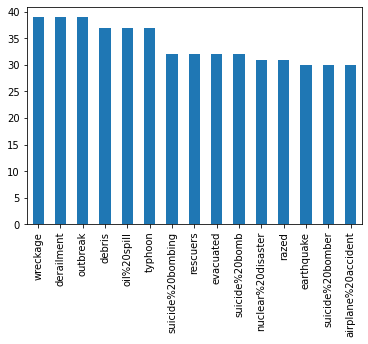

In [24]:
train[(train["target"] == 1)].keyword.value_counts()[0:15].plot.bar()


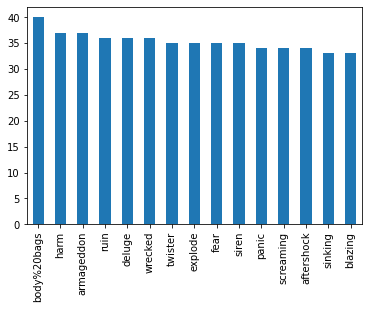

In [25]:
train[(train["target"] == 0)].keyword.value_counts()[0:15].plot.bar()

In [26]:
train["clean_keyword"] = ["Not Available" if pd.isna(each) else each for each in train["keyword"]]
test["clean_keyword"] = ["Not Available" if pd.isna(each) else each for each in test["keyword"]]

In [27]:
train["encoded_clean_keyword"] = le.fit_transform(train["clean_keyword"])
test["encoded_clean_keyword"] = le.transform(test["clean_keyword"])

In [28]:
def clean_text(tweet_df):
    new_tweet_list = []
    for each_tweet in tqdm(tweet_df):
        each_tweet = each_tweet.lower()
        each_tweet = re.sub(r"https?:[^\s]+(?= |$)", "", each_tweet)
        each_tweet = re.sub(r"@[^\s]+", "", each_tweet)
        each_tweet = re.sub(r"&amp;|\||Û|û", "", each_tweet)
        each_tweet = re.sub(r"[^a-z ]", "", each_tweet)
        twitter_slangs = r"|".join(["rt","tweet"])
        each_tweet = re.sub(twitter_slangs, "", each_tweet)
        #each_tweet = check(each_tweet)
        each_tweet = " ".join([lemmatizer.lemmatize(each_word) for each_word in each_tweet.split() if each_word not in stop_words])
        each_tweet = " ".join([normalize_json.get(each_word, each_word) for each_word in each_tweet.split()])
        #each_tweet = " ".join([sb_stemmer.stem(each_word) for each_word in word_tokenize(each_tweet) if each_word not in stop_words])

        
        new_tweet_list.append(each_tweet)
    new_tweet_df = pd.DataFrame(new_tweet_list)
    return new_tweet_df
train["clean_text"] = clean_text(train["text"])
test["clean_text"] = clean_text(test["text"])


100%|██████████| 7613/7613 [00:00<00:00, 34072.81it/s]

100%|██████████| 3263/3263 [00:00<00:00, 36621.82it/s]


In [29]:
train["clean_text"][train["clean_text"].duplicated()]

48                                             check nsfw
106     ir icemoon aftershock dubstep trapmusic dnb ed...
114     ir icemoon aftershock dubstep trapmusic dnb ed...
115     ir icemoon aftershock dubstep trapmusic dnb ed...
116     ir icemoon aftershock dubstep trapmusic dnb ed...
                              ...                        
7608      giant crane holding bridge collapse nearby home
7609     control wild fire california nohern pa troubling
7610                                 utckm volcano hawaii
7611    police investigating ebike collided car pougal...
7612    latest home razed nohern california wildfire a...
Name: clean_text, Length: 878, dtype: object

In [30]:
train["clean_text"][train[["clean_text", "target"]].duplicated()]

48                                             check nsfw
106     ir icemoon aftershock dubstep trapmusic dnb ed...
114     ir icemoon aftershock dubstep trapmusic dnb ed...
115     ir icemoon aftershock dubstep trapmusic dnb ed...
116     ir icemoon aftershock dubstep trapmusic dnb ed...
                              ...                        
7608      giant crane holding bridge collapse nearby home
7609     control wild fire california nohern pa troubling
7610                                 utckm volcano hawaii
7611    police investigating ebike collided car pougal...
7612    latest home razed nohern california wildfire a...
Name: clean_text, Length: 784, dtype: object

In [31]:
train["clean_text"][(list(set(train["clean_text"][train["clean_text"].duplicated()].index) - set(train["clean_text"][train[["clean_text", "target"]].duplicated()].index)))]

5641           wowo nigerian refugee repatriated cameroon
4618    clearedincident injuryi loop exit md georgia a...
4149      love picked playing woh harmkid ink listen vote
569     star war power jedi collection battle droid ha...
570     black eye space battle occurred star involving...
                              ...                        
6108                          feel sinking selfimage quiz
6634    medium pakistan covered capture terrorist moha...
3060                                       eahquake drill
2039                                               danger
2040    fettilootch slanglucci oppression greatest dan...
Name: clean_text, Length: 94, dtype: object

In [32]:
train = train.drop(list(set(train["clean_text"][train["clean_text"].duplicated()].index) - set(train["clean_text"][train[["clean_text", "target"]].duplicated()].index)))

In [33]:
train["clean_text"][train["clean_text"].duplicated()].count()

784

In [34]:
train = train.drop_duplicates(subset=["clean_text"], keep="first")

In [35]:
train.count()

id                       6735
keyword                  6684
location                 4527
text                     6735
target                   6735
clean_keyword            6735
encoded_clean_keyword    6735
clean_text               6735
dtype: int64

In [36]:
def plot_word_cloud(data):
    wordcloud = WordCloud(width = 2000, height = 2000,
                      background_color='white',
                min_font_size = 10).generate(data) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

## Corpus Word Cloud

  3%|▎         | 241/7613 [00:30<15:17,  8.04it/s]

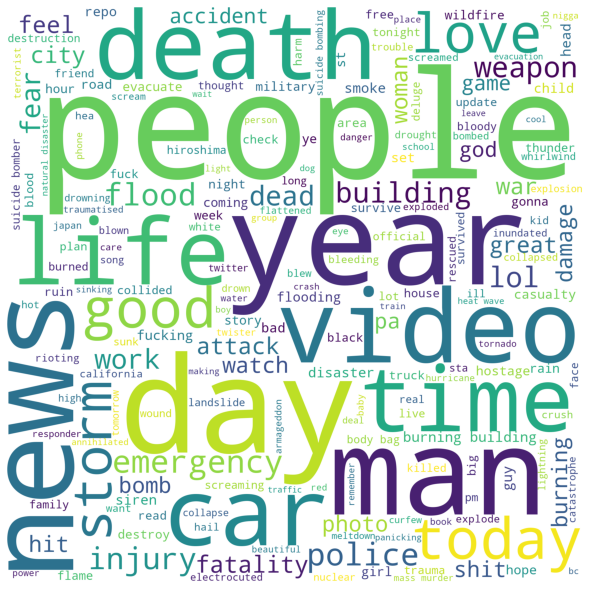

In [37]:
full_data = " ".join(train["clean_text"])
plot_word_cloud(full_data)

## Disaster Tweets Word Cloud

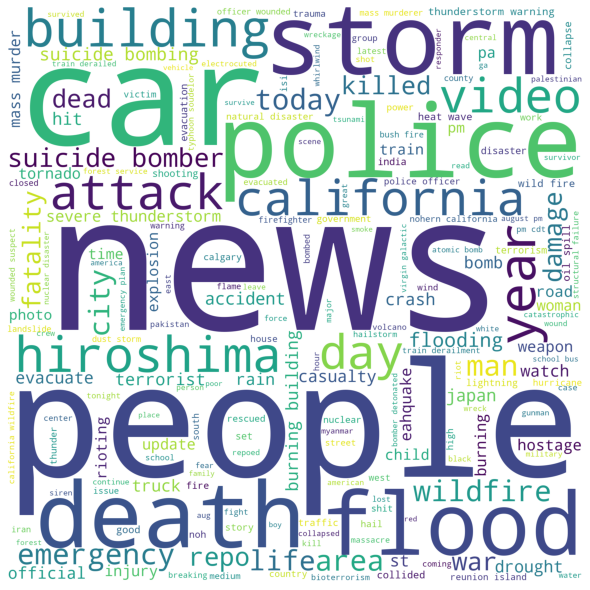

In [38]:
disaster_data = " ".join(train["clean_text"][(train["target"] == 1)])
plot_word_cloud(disaster_data)

## Non Disaster Tweets Word Cloud

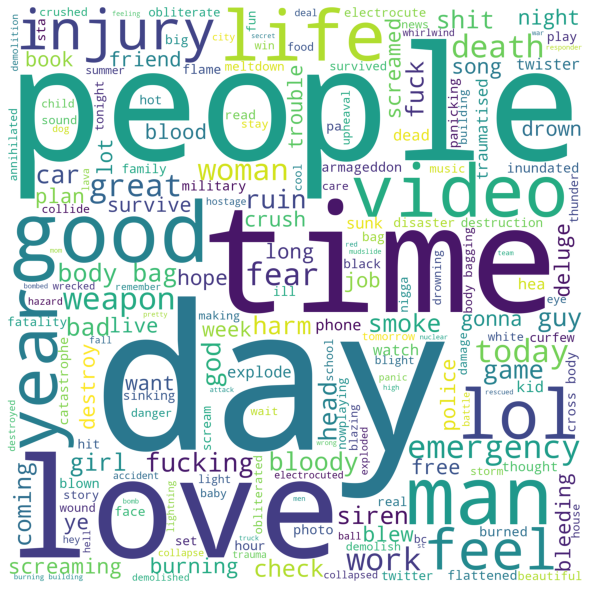

In [39]:
non_disaster_data = " ".join(train["clean_text"][(train["target"] == 0)])
plot_word_cloud(non_disaster_data)

In [40]:
train["target"].value_counts()

0    3964
1    2771
Name: target, dtype: int64

In [41]:
from sklearn.model_selection import train_test_split
x_train_df, x_val_df, y_train, y_val = train_test_split(train, train["target"], test_size=0.1)

In [42]:
x_train, x_val, x_test = x_train_df["clean_text"], x_val_df["clean_text"], test["clean_text"]

## TF-IDF Features

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=1)
train_tfidf = tfidf.fit_transform(x_train)
val_tfidf = tfidf.transform(x_val)
test_tfidf = tfidf.transform(x_test)

In [44]:
print(train_tfidf.shape)

(6061, 12283)


[ 0.00906153 -0.03892608]
[0.00906153 0.01741083 0.03356182 ... 0.0424315  0.0077152  0.02727964] [-0.03892608 -0.07377305 -0.09553832 ... -0.07454813 -0.02004395
 -0.05698157]


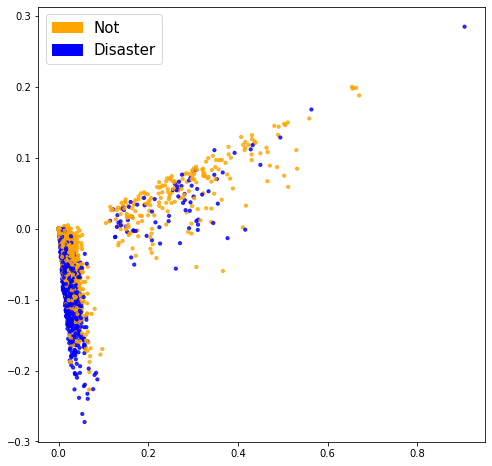

In [45]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches
def plot_LSA(data, labels):
    lsa = TruncatedSVD(n_components=2)
    lsa_scores = lsa.fit_transform(data)
    color_mapper = {label:idx for idx,label in enumerate(set(labels))}
    color_column = [color_mapper[label] for label in labels]
    colors = ['orange','blue']
    print(lsa_scores[0])
    print(lsa_scores[:,0], lsa_scores[:,1])
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=10, alpha=.8, c=labels, cmap=matplotlib.colors.ListedColormap(colors))
    orange_patch = mpatches.Patch(color='orange', label='Not')
    blue_patch = mpatches.Patch(color='blue', label='Disaster')
    plt.legend(handles=[orange_patch, blue_patch], prop={'size': 15})
    plt.show()
          
plot_LSA(train_tfidf, y_train)


# Logistic Regression With Tfidf Values

In [46]:
from sklearn.linear_model import LogisticRegression
logistic_regression_1 = LogisticRegression(C=0.8, solver="saga")
logistic_regression_1.fit(train_tfidf, y_train)
print(logistic_regression_1.score(train_tfidf, y_train))
print(logistic_regression_1.score(val_tfidf, y_val))

0.8721333113347632
0.7537091988130564


In [47]:
prediction = logistic_regression_1.predict(val_tfidf)

In [48]:
wrong_result = [(sent, each_pre) for index, sent, each_pre, each_or in zip(range(1,len(x_val) + 1), x_val, prediction, y_val) if each_pre != each_or]

In [49]:
wrong_result = pd.DataFrame(wrong_result, columns=["Sentence", "Wrong Label"])
wrong_result.to_csv("wrong_result.csv", index=False)

In [50]:
from sklearn.metrics import classification_report

In [51]:
print(classification_report(y_val, prediction))

              precision    recall  f1-score   support

           0       0.74      0.88      0.80       388
           1       0.78      0.59      0.67       286

    accuracy                           0.75       674
   macro avg       0.76      0.73      0.74       674
weighted avg       0.76      0.75      0.75       674



In [52]:
pred_result_logistic_1 = [each_prediction[1] for each_prediction in logistic_regression_1.predict_proba(val_tfidf)]

Area Under the Curve :  0.8347766923797851


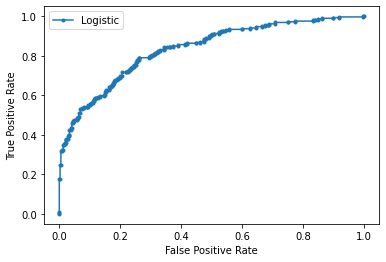

In [53]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
lr_auc = roc_auc_score(y_val, pred_result_logistic_1)
lr_fpr, lr_tpr, threshold  = roc_curve(y_val, pred_result_logistic_1)
print("Area Under the Curve : ", lr_auc)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [54]:
prediction_result = logistic_regression_1.predict(test_tfidf)
output_result = pd.DataFrame()
test_ids_df = pd.DataFrame(test["id"])
output_result["target"] = prediction_result
output = pd.concat([test_ids_df.reset_index(drop=True),output_result.reset_index(drop=True)], axis=1)
output.to_csv("submission.csv", index=False)